In [ ]:
import pandas as pd
import numpy as np
from scapy.all import rdpcap, TCP, IP
from collections import defaultdict
from tqdm.notebook import tqdm 
import warnings

warnings.filterwarnings("ignore", category=RuntimeWarning)

PCAP_FILE = "c:\\Users\\Shivansh\\Desktop\\ml_endterm_project\\202504021400.pcap"
OUTPUT_CSV = "c:\\Users\\Shivansh\\Desktop\\ml_endterm_project\\flows.csv"

In [ ]:
from scapy.all import PcapReader
from tqdm import tqdm

flows = defaultdict(list)
print("Reading a subset of 2 million packets and grouping them into flows...")

# Define a limit
packet_limit = 2000000 
count = 0

try:
    with PcapReader(PCAP_FILE) as pcap_reader:
        # progress bar
        for pkt in tqdm(pcap_reader, total=packet_limit, desc="Processing packets"):
            if count >= packet_limit:
                break # limit reached

            if IP in pkt and TCP in pkt:
                ip_layer = pkt[IP]
                tcp_layer = pkt[TCP]
                
                if ip_layer.src < ip_layer.dst:
                    flow_tuple = (ip_layer.src, tcp_layer.sport, ip_layer.dst, tcp_layer.dport)
                else:
                    flow_tuple = (ip_layer.dst, tcp_layer.dport, ip_layer.src, tcp_layer.sport)
                
                direction = 1 if flow_tuple[0] == ip_layer.src else -1
                
                flows[flow_tuple].append({
                    'time': float(pkt.time),
                    'size': len(pkt),
                    'dir': direction,
                    'seq': tcp_layer.seq,
                    'ack': tcp_layer.ack,
                    'payload_len': len(tcp_layer.payload)
                })
            count += 1

    print(f"\nSuccessfully processed {count} packets and identified {len(flows)} unique flows.")

except FileNotFoundError:
    print(f"ERROR: The file was not found at '{PCAP_FILE}'.")
except Exception as e:
    print(f"An error occurred: {e}")

Reading a subset of 2 million packets and grouping them into flows...


Processing packets: 100%|██████████| 2000000/2000000 [08:11<00:00, 4070.41it/s]



Successfully processed 2000000 packets and identified 131476 unique flows.


In [ ]:
#  MODIFIED APPROACH: Predict Packet Count-

processed_flows = []
print("Calculating features for each flow...")

for flow_tuple, flow_packets in tqdm(flows.items(), desc="Analyzing flows"):
    # We still want flows with a minimum number of packets to be meaningful
    if len(flow_packets) < 10:
        continue

    flow_packets.sort(key=lambda p: p['time'])

    timestamps = [p['time'] for p in flow_packets]
    flow_duration_sec = timestamps[-1] - timestamps[0]
    
    # Skip flows that are instantaneous
    if flow_duration_sec == 0:
        continue

    packet_sizes = [p['size'] for p in flow_packets]
    inter_arrival_times = np.diff(timestamps)

    # Our features (X) remain the same
    features = {
        'flow_duration_sec': flow_duration_sec,
        'total_bytes': sum(packet_sizes),
        'avg_packet_size': np.mean(packet_sizes),
        'mean_inter_arrival_ms': np.mean(inter_arrival_times) * 1000 if len(inter_arrival_times) > 0 else 0,
        'jitter_ms': np.std(inter_arrival_times) * 1000 if len(inter_arrival_times) > 0 else 0,
    }
    features['bandwidth_kbps'] = (features['total_bytes'] * 8) / (features['flow_duration_sec'] * 1000)
    
    # Our target (y) is now the total packet count
    features['packet_count'] = len(flow_packets)
    
    processed_flows.append(features)

print(f"\nSuccessfully created a dataset with {len(processed_flows)} flows.")

Calculating features for each flow...


Analyzing flows: 100%|██████████| 131476/131476 [00:01<00:00, 113935.52it/s]



Successfully created a dataset with 6707 flows.


In [ ]:
# Convert the list of dictionaries to a Pandas DataFrame
df = pd.DataFrame(processed_flows)

#  Save the DataFrame to a CSV file
try:
    df.to_csv(OUTPUT_CSV, index=False)
    print(f"Successfully saved {len(df)} flows to '{OUTPUT_CSV}'")
except Exception as e:
    print(f"An error occurred while saving the file: {e}")

print("\n--- Dataset Preview ---")
display(df.head())

print("\n--- Dataset Statistics ---")
display(df.describe())

Successfully saved 6707 flows to 'c:\Users\Shivansh\Desktop\ml_endterm_project\flows.csv'

--- Dataset Preview ---


,flow_duration_sec,total_bytes,avg_packet_size,mean_inter_arrival_ms,jitter_ms,bandwidth_kbps,packet_count
0,7.503481,814844,67.971638,0.625968,2.091379,868.763694,11988
1,4.509693,251912,67.284188,1.204834,11.450090,446.880983,3744
2,5.584770,1026,54.000000,310.264998,950.750799,1.469711,19
3,7.501556,275872,55.731717,1.515772,4.276566,294.202433,4950
4,7.275418,37908,54.000000,10.378628,110.663105,41.683378,702



--- Dataset Statistics ---


,flow_duration_sec,total_bytes,avg_packet_size,mean_inter_arrival_ms,jitter_ms,bandwidth_kbps,packet_count
count,6707.000000,6.707000e+03,6707.000000,6707.000000,6707.000000,6707.000000,6707.000000
mean,2.106418,7.936805e+03,60.715508,105.993223,206.968292,79.445282,132.319219
std,2.474466,4.871238e+04,5.985891,165.944050,325.209912,399.568736,841.139608
min,0.001049,5.400000e+02,54.000000,0.026835,0.060849,0.600527,10.000000
25%,0.204051,7.220000e+02,54.923077,9.005852,16.119959,4.279262,11.000000
50%,0.866231,9.980000e+02,58.000000,36.657310,65.137141,14.249938,16.000000
75%,3.532173,1.716000e+03,66.571429,118.881665,224.143792,58.163393,28.000000
max,7.504777,1.589124e+06,87.739130,807.027446,2116.960012,16100.799144,29428.000000


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# --- Data Preparation for Modeling ---

# 1. Load the data if needed
# df = pd.read_csv(OUTPUT_CSV)

# 2. Handle potential infinite values that may have resulted from division by a very small duration
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.dropna(inplace=True)
print(f"Removed infinite or NaN values. Shape after cleaning: {df.shape}")

# 3. Separate features (X) from the target variable (y)
X = df.drop('packet_count', axis=1)
y = df['packet_count']

# 4. Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 5. Feature Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("\nData preparation complete.")
print(f"Shape of X_train_scaled: {X_train_scaled.shape}")
print(f"Shape of X_test_scaled: {X_test_scaled.shape}")

Removed infinite or NaN values. Shape after cleaning: (6707, 7)

Data preparation complete.
Shape of X_train_scaled: (5365, 6)
Shape of X_test_scaled: (1342, 6)


Training the Random Forest Regressor model...
Model training complete.

Making predictions on the test data...

--- Model Evaluation ---
Mean Absolute Error (MAE): 12.51
R-squared (R²) Score: 0.9147

Interpretation:
- MAE means that, on average, the model's prediction for the packet count is off by about 13 packets.
- R² of 0.91 means that 91.5% of the variance in the packet count can be explained by our features.


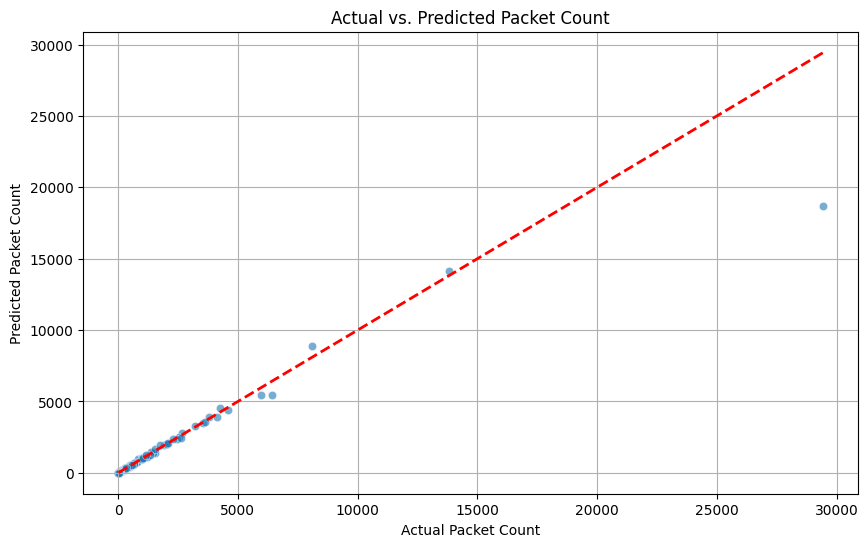

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Initialize and Train the Model
print("Training the Random Forest Regressor model...")
# n_estimators is the number of trees in the forest.
rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)

# Train the model on the scaled training data
rf_model.fit(X_train_scaled, y_train)
print("Model training complete.")

# --- 2. Make Predictions on the Test Set ---
print("\nMaking predictions on the test data...")
y_pred = rf_model.predict(X_test_scaled)

# --- 3. Evaluate Model Performance ---
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("\n--- Model Evaluation ---")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"R-squared (R²) Score: {r2:.4f}")
print("\nInterpretation:")
print(f"- MAE means that, on average, the model's prediction for the packet count is off by about {mae:.0f} packets.")
print(f"- R² of {r2:.2f} means that {r2*100:.1f}% of the variance in the packet count can be explained by our features.")

# --- 4. Visualize the Results ---
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r', linewidth=2)
plt.title('Actual vs. Predicted Packet Count')
plt.xlabel('Actual Packet Count')
plt.ylabel('Predicted Packet Count')
plt.grid(True)
plt.show()

In [ ]:
from sklearn.metrics import mean_squared_error, median_absolute_error
import numpy as np

# --- Calculate Additional Metrics ---
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse) # RMSE is the square root of MSE
medae = median_absolute_error(y_test, y_pred)

print("\n--- Additional Model Evaluation Metrics ---")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"Median Absolute Error (MedAE): {medae:.2f}")

print("\n--- Interpretation of New Metrics ---")
print(f"- RMSE of {rmse:.2f} is another way to measure the average error in terms of packets. It's more sensitive to large errors than MAE.")
print(f"- MedAE of {medae:.2f} is excellent. It means that for 50% of the flows in your test set, the model's prediction was off by only {medae:.2f} packets or less.")


--- Additional Model Evaluation Metrics ---
Mean Squared Error (MSE): 87258.54
Root Mean Squared Error (RMSE): 295.40
Median Absolute Error (MedAE): 0.00

--- Interpretation of New Metrics ---
- RMSE of 295.40 is another way to measure the average error in terms of packets. It's more sensitive to large errors than MAE.
- MedAE of 0.00 is excellent. It means that for 50% of the flows in your test set, the model's prediction was off by only 0.00 packets or less.


In [ ]:
# --- Test the Model with New, Hypothetical Data ---

# 1. Define some new example flows as a list of dictionaries
# The keys must match the feature names from your training data
new_flows_data = [
    {
        # Example 1: A short, high-bandwidth flow 
        'flow_duration_sec': 5.2,
        'total_bytes': 800000, # 800 KB
        'avg_packet_size': 1200,
        'mean_inter_arrival_ms': 15,
        'jitter_ms': 5,
        'bandwidth_kbps': (800000 * 8) / (5.2 * 1000) # ~1230 kbps
    },
    {
        # Example 2: A long, low-bandwidth flow
        'flow_duration_sec': 300.0, # 5 minutes
        'total_bytes': 15000000, # 15 MB
        'avg_packet_size': 800,
        'mean_inter_arrival_ms': 50,
        'jitter_ms': 20,
        'bandwidth_kbps': (15000000 * 8) / (300.0 * 1000) # 400 kbps
    },
    {
        # Example 3: A very short burst of traffic
        'flow_duration_sec': 0.8,
        'total_bytes': 50000, # 50 KB
        'avg_packet_size': 500,
        'mean_inter_arrival_ms': 80,
        'jitter_ms': 30,
        'bandwidth_kbps': (50000 * 8) / (0.8 * 1000) # 500 kbps
    }
]

# 2. Convert the new data into a Pandas DataFrame
# Ensure the column order is the same as the training data (X.columns)
new_flows_df = pd.DataFrame(new_flows_data, columns=X.columns)

print("--- New Hypothetical Flow Data ---")
display(new_flows_df)

# 3. Scale the new data using the SAME scaler that was fitted on the training data
new_flows_scaled = scaler.transform(new_flows_df)

# 4. Use the trained model to make predictions
predicted_counts = rf_model.predict(new_flows_scaled)

# 5. Display the results
print("\n--- Model Predictions ---")
for i, prediction in enumerate(predicted_counts):
    print(f"Prediction for Flow #{i+1}: {prediction:.0f} packets")

--- New Hypothetical Flow Data ---


,flow_duration_sec,total_bytes,avg_packet_size,mean_inter_arrival_ms,jitter_ms,bandwidth_kbps
0,5.2,800000,1200,15,5,1230.769231
1,300.0,15000000,800,50,20,400.000000
2,0.8,50000,500,80,30,500.000000



--- Model Predictions ---
Prediction for Flow #1: 11821 packets
Prediction for Flow #2: 20318 packets
Prediction for Flow #3: 779 packets
